In [1]:
import pandas as pd
import numpy as np
import requests
import math
from scipy import stats
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
from keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.api as smt
from statsmodels.tsa.api import VAR
from statsmodels.stats.stattools import durbin_watson
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
df = pd.read_csv('../Source/DAX.csv')

In [3]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-04,25.910000,25.910000,25.612000,25.700001,25.041664,2800
1,2019-03-05,25.731001,25.731001,25.700001,25.700001,25.041664,500
2,2019-03-06,25.780001,25.780001,25.650000,25.660000,25.002687,700
3,2019-03-07,25.240000,25.299999,25.230000,25.231001,24.584679,7400
4,2019-03-08,25.191000,25.191000,25.191000,25.191000,24.545704,400
...,...,...,...,...,...,...,...
247,2020-02-25,26.799999,26.799999,26.124001,26.150000,26.150000,16900
248,2020-02-26,26.260000,26.464001,26.100000,26.170000,26.170000,3300
249,2020-02-27,25.620001,26.003000,25.209999,25.209999,25.209999,10700
250,2020-02-28,24.510000,24.995001,24.473000,24.950001,24.950001,6400


In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-04,25.910000,25.910000,25.612000,25.700001,25.041664,2800
1,2019-03-05,25.731001,25.731001,25.700001,25.700001,25.041664,500
2,2019-03-06,25.780001,25.780001,25.650000,25.660000,25.002687,700
3,2019-03-07,25.240000,25.299999,25.230000,25.231001,24.584679,7400
4,2019-03-08,25.191000,25.191000,25.191000,25.191000,24.545704,400
...,...,...,...,...,...,...,...
247,2020-02-25,26.799999,26.799999,26.124001,26.150000,26.150000,16900
248,2020-02-26,26.260000,26.464001,26.100000,26.170000,26.170000,3300
249,2020-02-27,25.620001,26.003000,25.209999,25.209999,25.209999,10700
250,2020-02-28,24.510000,24.995001,24.473000,24.950001,24.950001,6400


In [5]:
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

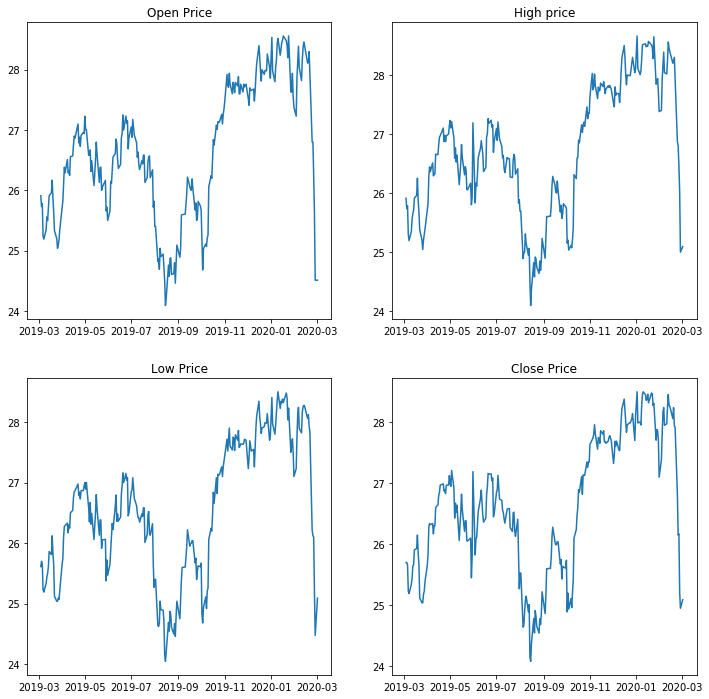

In [6]:
fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(12,12))
axes[0,0].plot(df['Date'], df['Open'])
axes[0,0].set_title('Open Price')
axes[0,1].plot(df['Date'],df['High'])
axes[0,1].set_title('High price')
axes[1,0].plot(df['Date'], df['Low'])
axes[1,0].set_title('Low Price')
axes[1,1].plot(df['Date'],df['Close'])
axes[1,1].set_title('Close Price')
plt.show()

In [7]:
# This function tests the null hypothesis that a sample comes from a normal distribution.
def norm_dist(tested):
    nh = 0.05
    Stats, p = stats.normaltest(tested)
    print('Statistic: ', Stats, 'Pvalue: ', p)
    if p > nh:
        return 'El dataset es una distribucion normal'
    else:
        return 'El dataset no es una distribucion normal'
    
    


In [8]:
norm_dist(df['Open'])

Statistic:  32.273383426422576 Pvalue:  9.815757776820127e-08


'El dataset no es una distribucion normal'

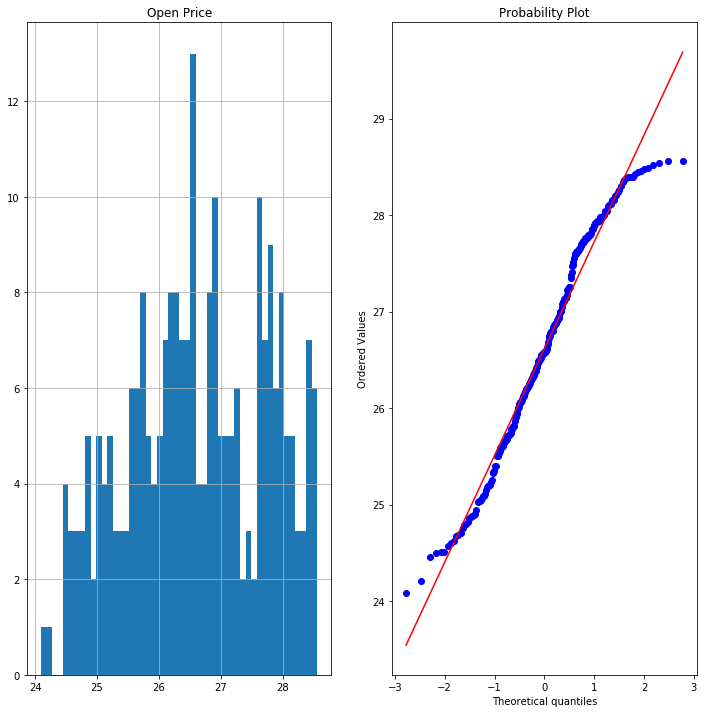

In [9]:
# Ploteo de el histograma de los datos
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
df['Open'].hist(bins=50)
plt.title('Open Price')
plt.subplot(1,2,2)
stats.probplot(df['Open'],plot=plt)
plt.show()

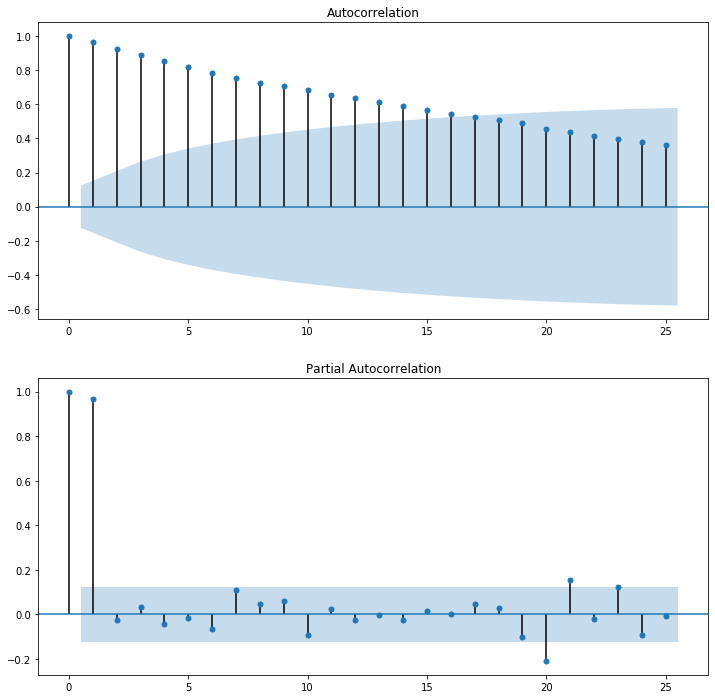

In [10]:
fig, axes = plt.subplots(2,figsize=(12,12))
axes[0] = plot_acf(df['Open'], ax=axes[0])
axes[1] = plot_pacf(df['Open'], ax=axes[1])

In [11]:
df.shape

(252, 7)

In [12]:
difer =math.ceil(len(df) *.8)

In [13]:
X_train, X_test = df[0:-15], df[-15:]

In [14]:
print('Train shape: ', X_train.shape, 'Test shape: ', X_test.shape)

Train shape:  (237, 7) Test shape:  (15, 7)


In [15]:
df.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [16]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-04,25.910000,25.910000,25.612000,25.700001,25.041664,2800
1,2019-03-05,25.731001,25.731001,25.700001,25.700001,25.041664,500
2,2019-03-06,25.780001,25.780001,25.650000,25.660000,25.002687,700
3,2019-03-07,25.240000,25.299999,25.230000,25.231001,24.584679,7400
4,2019-03-08,25.191000,25.191000,25.191000,25.191000,24.545704,400
...,...,...,...,...,...,...,...
247,2020-02-25,26.799999,26.799999,26.124001,26.150000,26.150000,16900
248,2020-02-26,26.260000,26.464001,26.100000,26.170000,26.170000,3300
249,2020-02-27,25.620001,26.003000,25.209999,25.209999,25.209999,10700
250,2020-02-28,24.510000,24.995001,24.473000,24.950001,24.950001,6400


In [17]:
transform_data = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].diff().dropna()
transform_data

,Open,High,Low,Close,Adj Close,Volume
1,-0.178999,-0.178999,0.088001,0.000000,0.000000,-2300.0
2,0.049000,0.049000,-0.050001,-0.040001,-0.038977,200.0
3,-0.540001,-0.480002,-0.420000,-0.428999,-0.418008,6700.0
4,-0.049000,-0.108999,-0.039000,-0.040001,-0.038975,-7000.0
5,0.149000,0.153999,0.139999,0.149000,0.145182,2100.0
...,...,...,...,...,...,...
247,0.000000,-0.069000,-0.090000,-0.665001,-0.665001,12000.0
248,-0.539999,-0.335998,-0.024001,0.020000,0.020000,-13600.0
249,-0.639999,-0.461001,-0.890001,-0.960001,-0.960001,7400.0
250,-1.110001,-1.007999,-0.736999,-0.259998,-0.259998,-4300.0


In [18]:
concat_data = transform_data.join(df['Date'])

In [19]:
concat_data

,Open,High,Low,Close,Adj Close,Volume,Date
1,-0.178999,-0.178999,0.088001,0.000000,0.000000,-2300.0,2019-03-05
2,0.049000,0.049000,-0.050001,-0.040001,-0.038977,200.0,2019-03-06
3,-0.540001,-0.480002,-0.420000,-0.428999,-0.418008,6700.0,2019-03-07
4,-0.049000,-0.108999,-0.039000,-0.040001,-0.038975,-7000.0,2019-03-08
5,0.149000,0.153999,0.139999,0.149000,0.145182,2100.0,2019-03-11
...,...,...,...,...,...,...,...
247,0.000000,-0.069000,-0.090000,-0.665001,-0.665001,12000.0,2020-02-25
248,-0.539999,-0.335998,-0.024001,0.020000,0.020000,-13600.0,2020-02-26
249,-0.639999,-0.461001,-0.890001,-0.960001,-0.960001,7400.0,2020-02-27
250,-1.110001,-1.007999,-0.736999,-0.259998,-0.259998,-4300.0,2020-02-28


In [20]:
concat_data = concat_data[['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]

In [21]:
concat_data

,Date,Open,High,Low,Close,Adj Close,Volume
1,2019-03-05,-0.178999,-0.178999,0.088001,0.000000,0.000000,-2300.0
2,2019-03-06,0.049000,0.049000,-0.050001,-0.040001,-0.038977,200.0
3,2019-03-07,-0.540001,-0.480002,-0.420000,-0.428999,-0.418008,6700.0
4,2019-03-08,-0.049000,-0.108999,-0.039000,-0.040001,-0.038975,-7000.0
5,2019-03-11,0.149000,0.153999,0.139999,0.149000,0.145182,2100.0
...,...,...,...,...,...,...,...
247,2020-02-25,0.000000,-0.069000,-0.090000,-0.665001,-0.665001,12000.0
248,2020-02-26,-0.539999,-0.335998,-0.024001,0.020000,0.020000,-13600.0
249,2020-02-27,-0.639999,-0.461001,-0.890001,-0.960001,-0.960001,7400.0
250,2020-02-28,-1.110001,-1.007999,-0.736999,-0.259998,-0.259998,-4300.0


In [22]:
concat_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,251.0,-0.005578,0.270096,-1.142000,-0.170000,0.010001,0.178499,0.799999
High,251.0,-0.003267,0.278346,-1.360001,-0.147501,0.013999,0.161500,1.266001
Low,251.0,-0.002080,0.282026,-1.625000,-0.121501,0.039000,0.175002,0.799999
Close,251.0,-0.002430,0.290741,-1.365000,-0.113999,0.020000,0.175002,1.389000
Adj Close,251.0,0.000193,0.285251,-1.330036,-0.106033,0.019998,0.174982,1.353422
Volume,251.0,-8.633466,17862.523851,-173000.000000,-1600.000000,-100.000000,1900.000000,175900.000000


In [23]:
def adfull(dataset):
    nh = 0.05
    test = adfuller(dataset, autolag='AIC')
    output = {'test statistic: ': test[0], 'pvalue': test[1], 'used lag: ': test[2], 'Number of observations': test[3]}
    print(output)
    if test[1] > nh:
        return 'Los datos no son estacionarios, ya que el pvalue es mayor al 5% ' 
    return 'Los datos son estacionarios'


adfull(concat_data['High'])

{'test statistic: ': -17.218717172665617, 'pvalue': 6.3001732067904374e-30, 'used lag: ': 0, 'Number of observations': 250}


'Los datos son estacionarios'

In [24]:
adfull(concat_data['Close'])

{'test statistic: ': -16.984504702609403, 'pvalue': 8.962012292021356e-30, 'used lag: ': 0, 'Number of observations': 250}


'Los datos son estacionarios'

In [25]:
adfull(concat_data['Open'])

{'test statistic: ': -15.797645141763065, 'pvalue': 1.083442990802916e-28, 'used lag: ': 0, 'Number of observations': 250}


'Los datos son estacionarios'

In [26]:
adfull(concat_data['Low'])

{'test statistic: ': -6.6668900909252935, 'pvalue': 4.693088210348469e-09, 'used lag: ': 3, 'Number of observations': 247}


'Los datos son estacionarios'

Text(0.5, 1.0, 'Close Price')

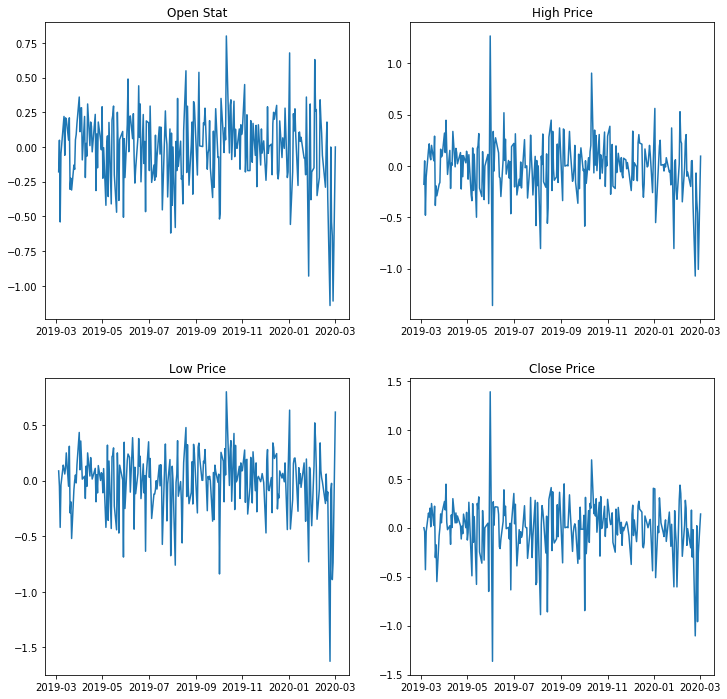

In [27]:
fig, axes = plt.subplots(2,2, figsize=(12,12))
axes[0,0].plot(concat_data['Date'], concat_data['Open'])
axes[0,0].set_title('Open Stat')
axes[0,1].plot(concat_data['Date'], concat_data['High'])
axes[0,1].set_title('High Price')
axes[1,0].plot(concat_data['Date'], concat_data['Low'])
axes[1,0].set_title('Low Price')
axes[1,1].plot(concat_data['Date'],concat_data['Close'])
axes[1,1].set_title('Close Price')

In [28]:
X_train = X_train.set_index('Date')

In [29]:
X_train.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [30]:
X_train.index

DatetimeIndex(['2019-03-04', '2019-03-05', '2019-03-06', '2019-03-07',
               '2019-03-08', '2019-03-11', '2019-03-12', '2019-03-13',
               '2019-03-14', '2019-03-15',
               ...
               '2020-01-27', '2020-01-28', '2020-01-29', '2020-01-30',
               '2020-01-31', '2020-02-03', '2020-02-04', '2020-02-05',
               '2020-02-06', '2020-02-07'],
              dtype='datetime64[ns]', name='Date', length=237, freq=None)

def grangers_caus_test(data, variables,verbose=False):
    X_train = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in X_train.columns:
        for r in X_train.index:
            test_result = grangercausalitytests(data[[r,c]],maxlag=12,verbose=False )
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(12)]
            if verbose: print()
            min_p_value = np.min(p_values)
            X_train.loc[r,c] = min_p_value
            
    X_train.columns = [var + '_x' for var in variables]
    X_train.index = [var +'_y' for var in variables]
    return X_train

grangers_caus_test(X_train,variables=X_train.columns)

In [31]:
concat_data

,Date,Open,High,Low,Close,Adj Close,Volume
1,2019-03-05,-0.178999,-0.178999,0.088001,0.000000,0.000000,-2300.0
2,2019-03-06,0.049000,0.049000,-0.050001,-0.040001,-0.038977,200.0
3,2019-03-07,-0.540001,-0.480002,-0.420000,-0.428999,-0.418008,6700.0
4,2019-03-08,-0.049000,-0.108999,-0.039000,-0.040001,-0.038975,-7000.0
5,2019-03-11,0.149000,0.153999,0.139999,0.149000,0.145182,2100.0
...,...,...,...,...,...,...,...
247,2020-02-25,0.000000,-0.069000,-0.090000,-0.665001,-0.665001,12000.0
248,2020-02-26,-0.539999,-0.335998,-0.024001,0.020000,0.020000,-13600.0
249,2020-02-27,-0.639999,-0.461001,-0.890001,-0.960001,-0.960001,7400.0
250,2020-02-28,-1.110001,-1.007999,-0.736999,-0.259998,-0.259998,-4300.0


In [32]:
new_concat = concat_data.set_index('Date')
new_concat

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-03-05,-0.178999,-0.178999,0.088001,0.000000,0.000000,-2300.0
2019-03-06,0.049000,0.049000,-0.050001,-0.040001,-0.038977,200.0
2019-03-07,-0.540001,-0.480002,-0.420000,-0.428999,-0.418008,6700.0
2019-03-08,-0.049000,-0.108999,-0.039000,-0.040001,-0.038975,-7000.0
2019-03-11,0.149000,0.153999,0.139999,0.149000,0.145182,2100.0
...,...,...,...,...,...,...
2020-02-25,0.000000,-0.069000,-0.090000,-0.665001,-0.665001,12000.0
2020-02-26,-0.539999,-0.335998,-0.024001,0.020000,0.020000,-13600.0
2020-02-27,-0.639999,-0.461001,-0.890001,-0.960001,-0.960001,7400.0


In [33]:
mod = smt.VAR(new_concat)
res = mod.fit(maxlags=3)
print(res.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 02, Mar, 2020
Time:                     15:28:03
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                  -0.997839
Nobs:                     248.000    HQIC:                  -1.96273
Log likelihood:          -1673.38    FPE:                  0.0734554
AIC:                     -2.61288    Det(Omega_mle):       0.0471700
--------------------------------------------------------------------
Results for equation Open
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const               -0.003842         0.016127           -0.238           0.812
L1.Open             -0.154364         0.218468           -0.707           0.480
L1.High             -0.618702         0.221133           -2.798  

In [34]:
# Durbin Watson Statistic 
out = durbin_watson(res.resid)
for col,val in zip(concat_data.columns,out):
    print((col), ':', round(val,2))

Date : 2.03
Open : 2.02
High : 1.97
Low : 2.02
Close : 2.02
Adj Close : 2.06


In [35]:
len(concat_data.values[-15:])

15

In [47]:
pred = res.forecast(new_concat.values[:6],30)
pred_df = pd.DataFrame(pred,index=new_concat.index[-30:],columns=new_concat.columns)
pred_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-17,-0.033368,-0.033499,0.030418,0.010131,0.013708,-470.691618
2020-01-21,0.008619,0.027604,0.005996,0.041274,0.043227,-1121.988275
2020-01-22,0.010397,-0.002186,-0.010676,-0.015284,-0.010514,2012.896271
2020-01-23,0.018151,0.009474,0.020537,0.002143,0.004261,-861.589524
2020-01-24,-0.005336,0.002845,-0.001523,0.005239,0.007652,-18.223841
2020-01-27,-0.010340,-0.002888,-0.008756,0.000062,0.002970,-82.196192
2020-01-28,0.002895,0.000418,0.002860,-0.000958,0.001867,270.620541
2020-01-29,0.000477,-0.000617,0.000109,-0.002085,0.000362,-35.487147
2020-01-30,-0.004218,-0.001230,-0.002953,-0.001584,0.000864,-54.859992


In [37]:
pred_inverse = pred_df.cumsum()
pred_inverse

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-17,-0.033368,-0.033499,0.030418,0.010131,0.013708,-470.691618
2020-01-21,-0.024749,-0.005895,0.036414,0.051405,0.056935,-1592.679893
2020-01-22,-0.014352,-0.008081,0.025738,0.036122,0.046421,420.216378
2020-01-23,0.003799,0.001392,0.046275,0.038264,0.050682,-441.373146
2020-01-24,-0.001536,0.004237,0.044752,0.043504,0.058333,-459.596986
2020-01-27,-0.011877,0.001350,0.035996,0.043566,0.061303,-541.793178
2020-01-28,-0.008981,0.001768,0.038856,0.042608,0.063170,-271.172637
2020-01-29,-0.008504,0.001150,0.038965,0.040523,0.063532,-306.659785
2020-01-30,-0.012722,-0.000080,0.036013,0.038939,0.064396,-361.519777


In [38]:
X_test = X_test.set_index('Date')

In [39]:
f = pred_inverse + X_test
f = f.dropna()

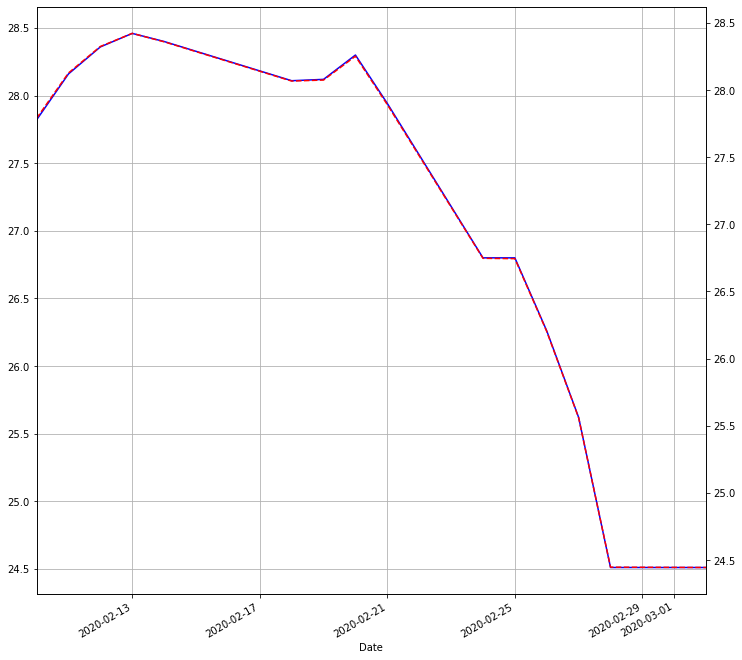

In [40]:
plt.figure(figsize=(12,12))
ax1= X_test.Open.plot(c='blue',grid=True, label='Open Price')
ax2= f.Open.plot(c='red', ls='--',grid=True,secondary_y=True,label='Precio Open Original')
plt.show()

In [41]:
f

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-02-10,27.789637,28.010581,27.844440,28.005635,28.049240,12468.888072
2020-02-11,28.127105,28.247608,28.182735,28.284297,28.330473,2482.191258
2020-02-12,28.324570,28.551651,28.271051,28.483007,28.531762,4697.778802
2020-02-13,28.422060,28.450691,28.294385,28.301702,28.353035,613.438660
2020-02-14,28.359531,28.389710,28.282700,28.290390,28.344299,2427.873908
2020-02-18,28.067011,28.188740,28.076017,28.084074,28.140558,2342.865171
2020-02-19,28.074487,28.235767,28.134339,28.262766,28.321827,1157.982087
2020-02-20,28.251965,28.286799,27.952661,27.961457,28.023095,1672.935806
2020-02-21,27.891439,27.927826,27.849979,27.940146,28.004360,787.831054


In [42]:
# evaluacion del forecast
forecast_errors = [X_test.Open[i]-f.Open[i] for i in range(len(X_test.Open))]
bias = sum(forecast_errors)* 1.0/len(X_test.Open)
print(bias)

0.0480352542342113


In [43]:
mae = mean_absolute_error(X_test.Open,f.Open)
mse = mean_squared_error(X_test.Open, f.Open)
print('Mean abosolute error: ',mae,'mean squared error: ', mse )

Mean abosolute error:  0.0480352542342113 mean squared error:  0.0024262253713863285


In [44]:
# 